<a href="https://colab.research.google.com/github/vittoria-thomasini/Extract_skintone_image/blob/main/Extract_Skin_Tone_from_an_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to extract Skin from and Image and Find the Dominant Colours/Tone

This the online notebook containing the explaination of the code for the article found at https://goo.gl/bpkVn3

If you are interested in testing out with code create a copy of this notebook and go to  menu on top "Runtime -> Run All"


In [1]:
!pip install imutils
!pip install xmltodict

## Section One : Importing Libraries

 - **numpy** : OpenCV uses Numpy for numerical operation. Hence Numpy is used to align input with the respective data type

 - **cv2** : OpenCV used for image processing

 - **Counter** : Useful for counting labels

 - **imutils** :  Useful utilities for image processing

 - **pprint** :  Library to pretty print data

 - **matplotlib** :  Normally used as a graph plotting lirbary , but we will use it show inline images since "cv2.imshow" doesn't work on collab

 - **pandas** :
 - **urllib** :

In [2]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
import pprint
from matplotlib import pyplot as plt
import pandas as pd
import urllib.request

MST Swatches are 10 single-colored rectangles, and each swatch provides the most representative color within its MST group. The swatches are created for researchers who need to use the exact color values of the MST scale for their studies and for reference when running evaluations.
Color format used is CIE-LAB, but its possible to use HEX, HSL, RGB and CIE-LCH.
Can check information mentioned on https://skintone.google/get-started

In [3]:
#skinMap =
#lab(94.211, 1.503, 5.422)
#lab(92.275, 2.061, 7.28)
#lab(93.091, 0.216, 14.205)
#lab(87.573, 0.459, 17.748)
#lab(77.902, 3.471, 23.136)
#lab(55.142, 7.783, 26.74)
#lab(42.47, 12.325, 20.53)
#lab(30.678, 11.667, 13.335)
#lab(21.069, 2.69, 5.964)
#lab(14.61, 1.482, 3.525)

## Section Two.1 : Function to Extract Skin Color





Read files from github repository and create a local copy in real time to not be mandatory have the files in the machine.
The files for nose and mouth identification are not from the official haarcascad repository but from a second one shared by the community link below.

NOSE and MOUTH xml -> https://github.com/atduskgreg/opencv-processing/tree/master/lib/cascade-files

In [4]:
import requests
import urllib3
def create_file(url, name, extension):
  file_url = url
  http     = urllib3.PoolManager()
  response = http.request('GET', file_url)
  data     = response.data.decode('utf-8')
  file_name = name + '.' + extension

  with open(file_name, 'w') as arquivo:
      arquivo.write(data)

  file_path = '/content/'+ file_name

  return file_path
create_file('https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/haarcascade/haarcascade_mcs_mouth.xml', 'haarcascade_mcs_mouth', 'xml')
create_file('https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/haarcascade/haarcascade_mcs_nose.xml', 'haarcascade_mcs_nose', 'xml')
create_file('https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/6ea08df8350b27a95f4856c710f5239279559413/mst-e_dataset_details.csv', 'dataset_details', 'csv')

'/content/dataset_details.csv'

The ***extractSkin*** function takes an 8 bit 3 channel image in the BGR colorspace (as mentioned in the article this is how OpenCV reads color images) and returns the extracted image in same colorspace.

The function works by using the** HSV colorspace** and uses thresholding (Thresholding is a process of filtering out pixel based on specified thresdhold parameter) to extracts pixel that corresponds to the skin color range,

In [5]:
def featuresIdentification(image):
  global cropped_image

  #Upload xml
  mouth_xml = r'/content/haarcascade_mcs_mouth.xml'
  nose_xml = r'/content/haarcascade_mcs_nose.xml'

  #read xml
  face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  eye_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
  mouth_detector = cv2.CascadeClassifier(mouth_xml)
  nose_detector = cv2.CascadeClassifier(nose_xml)

  #Convert image from BGR to GRAY
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
  faces = face_detector.detectMultiScale(gray,
                                        scaleFactor=1.05,
                                        minNeighbors=5)

  # For each face
  for (x, y, w, h) in faces:
      # Draw rectangle around the face
      cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 0, 0), 2)
      roi_face = gray[y:y+h, x:x+w]
      cropped_image = image[y:y+h, x:x+w]
      print("aqui crop FACE")
      plt.imshow(cropped_image)
      plt.show()

  if not cropped_image.any():
    print("Não Identificado Rosto")
    cropped_image = gray
  # Detect eye
  eyes = eye_detector.detectMultiScale(cropped_image,
                                       scaleFactor=1.05,
                                       minNeighbors=5)
  for (ex,ey,ew,eh) in eyes:
      cv2.rectangle(cropped_image,(ex,ey),(ex+ew,ey+eh),(0,0,0),-2)
      # cropped_image = img[y:y+h, x:x+w]
      # roi_eye = roi_face[y:y+h, x:x+w]

  # Detect mouth
  mouth = mouth_detector.detectMultiScale(cropped_image,
                                       scaleFactor=1.05,
                                       minNeighbors=5)
  for (xm,ym,wm,hm) in mouth:
      cv2.rectangle(cropped_image,(xm,ym),(xm+wm,ym+hm),(0,0,0),-2)
      # cropped_image = image[y:y+h, x:x+w]
      # roi_mouth = roi_face[y:y+h, x:x+w]
  # print("aqui crop BOCA")
  # plt.imshow(cropped_image)
  # plt.show()

  # Detect nose
  nose = nose_detector.detectMultiScale(cropped_image,
                                       scaleFactor=1.05,
                                       minNeighbors=5)
  for (xn,yn,wn,hn) in nose:
      cv2.rectangle(cropped_image,(xn,yn),(xn+wn,yn+hn),(0,0,0),-2)
      # cropped_image = image[y:y+h, x:x+w]
      # roi_nose = roi_face[y:y+h, x:x+w]
      # print("cropped image in nose")
      # plt.imshow(cropped_image)
      # plt.show()

  # Converting from BGR Colours Space to HSV
  output =  cv2.cvtColor(cropped_image,cv2.COLOR_BGR2HSV)
  plt.imshow(output)
  plt.show()
  return output


In [6]:
def extractSkin(image):
    # Takin image without features
    img = featuresIdentification(image)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

## Section Two.2 :  Function to remove black pixels from extracted image

The ***removeBlack*** function is more sort of the utility function to remove out the black pixel from the skin extracted. Since OpenCV by default doesn't handle transparent images and replaces those with zeros(black in color word).

This function is useful when thresholding is used in the image.

In [7]:
def removeBlack(estimator_labels, estimator_cluster):

  # Check for black
  hasBlack = False

  # Get the total number of occurance for each color
  occurance_counter = Counter(estimator_labels)


  # Quick lambda function to compare to lists
  compare = lambda x, y: Counter(x) == Counter(y)

  # Loop through the most common occuring color
  for x in occurance_counter.most_common(len(estimator_cluster)):

    # Quick List comprehension to convert each of RBG Numbers to int
    color = [int(i) for i in estimator_cluster[x[0]].tolist() ]



    # Check if the color is [0,0,0] that if it is black
    if compare(color , [0,0,0]) == True:
      # delete the occurance
      del occurance_counter[x[0]]
      # remove the cluster
      hasBlack = True
      estimator_cluster = np.delete(estimator_cluster,x[0],0)
      break


  return (occurance_counter,estimator_cluster,hasBlack)



## Section Two.3 : Extract Colour Information

The ***getColorInfomation*** function does all the heavy lifiting to make sense of prediction that came from the clustering.

Taking the prediction labels (***estimator_labels***) and the cluster centroids(***estimator_cluster***) as the input and returns an array of dictionaries of the extracted colours.

The function also takes an optional parameter (***hasThresholding***) to indicate whether a mask was used. This passed from the ***extractDominantColor*** function


In [8]:
def getColorInformation(estimator_labels, estimator_cluster,hasThresholding=False):

  # Variable to keep count of the occurance of each color predicted
  occurance_counter = None

  # Output list variable to return
  colorInformation = []


  #Check for Black
  hasBlack =False

  # If a mask has be applied, remove th black
  if hasThresholding == True:

    (occurance,cluster,black) = removeBlack(estimator_labels,estimator_cluster)
    occurance_counter =  occurance
    estimator_cluster = cluster
    hasBlack = black

  else:
    occurance_counter = Counter(estimator_labels)

  # Get the total sum of all the predicted occurances
  totalOccurance = sum(occurance_counter.values())


  # Loop through all the predicted colors
  for x in occurance_counter.most_common(len(estimator_cluster)):

    index = (int(x[0]))

    # Quick fix for index out of bound when there is no threshold
    index =  (index-1) if ((hasThresholding & hasBlack)& (int(index) !=0)) else index

    # Get the color number into a list
    color = estimator_cluster[index].tolist()

    # Get the percentage of each color
    color_percentage= (x[1]/totalOccurance)

    #make the dictionay of the information
    colorInfo = {"cluster_index":index , "color": color , "color_percentage" : color_percentage }

    # Add the dictionary to the list
    colorInformation.append(colorInfo)


  return colorInformation

## Section Two.4 : Putting it All together

The ***extractDominantColor*** is the function that call the above function to output the information.

The function take an 8 bit 3 channel BGR image as the input , the number of colors to be extracted. This does all the super heavy lifting by sparkling some magic power of machine learning.


As mention in the article , An unsupervised clustering algorithm, ***KMeans Clustering*** is used to cluster the pixel data based on their RGB values.


The function also takes an optional parameter (***hasThresholding***) to indicate whether a thresholding mask was used. This passed to the ***getColorInformation*** function




img.reshape tem o papel de mudar o formato do array sem mudar o conteudo

In [9]:
from sklearn import cluster

def extractDominantColor(image,number_of_colors=10,hasThresholding=False):

  # Quick Fix Increase cluster counter to neglect the black(Read Article)
  if hasThresholding == True:
    number_of_colors +=1

  # Taking Copy of the image
  img = image.copy()

  # Convert Image into RGB Colours Space
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  # Reshape Image
  img = img.reshape((img.shape[0]*img.shape[1]) , 3)

  #Initiate KMeans Object
  estimator = KMeans(n_clusters=number_of_colors, random_state=0)

  # Fit the image
  estimator.fit(img)

  # Get Colour Information
  colorInformation = getColorInformation(estimator.labels_,estimator.cluster_centers_,hasThresholding)
  return colorInformation
  print(colorInformation)

https://towardsdatascience.com/kmeans-clustering-for-classification-74b992405d0a

In [10]:
import numpy as np
import pandas as pd
import time
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed
class clust():
    def _load_data(self, sklearn_load_ds):
        data = sklearn_load_ds
        X = pd.DataFrame(data.data)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, data.target, test_size=0.3, random_state=42)

    def __init__(self, sklearn_load_ds):
        self._load_data(sklearn_load_ds)

    @timeit
    def classify(self, model=LogisticRegression(random_state=42)):
        model.fit(self.X_train, self.y_train)
        y_pred = model.predict(self.X_test)
        print('Accuracy: {}'.format(accuracy_score(self.y_test, y_pred)))

    @timeit
    def Kmeans(self, output='add'):
        n_clusters = len(np.unique(self.y_train))
        clf = KMeans(n_clusters = n_clusters, random_state=42)
        clf.fit(self.X_train)
        y_labels_train = clf.labels_
        y_labels_test = clf.predict(self.X_test)
        if output == 'add':
            self.X_train['km_clust'] = y_labels_train
            self.X_test['km_clust'] = y_labels_test
        elif output == 'replace':
            self.X_train = y_labels_train[:, np.newaxis]
            self.X_test = y_labels_test[:, np.newaxis]
        else:
            raise ValueError('output should be either add or replace')
        return self

clust(load_digits()).Kmeans(output='replace').classify(model=SVC())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'Kmeans'  732.93 ms
Accuracy: 0.7833333333333333
'classify'  32.35 ms


## Section Two.4.1 : Putting it All together: Making a Visually Representation

The ***plotColorBar*** function gives a visually representation of the extracted color information.

Taking the color information (***colorInformation***) as input  and returns
 ***500x100 8 bit 3 channel BGR colorspace image***

In [11]:
def plotColorBar(colorInformation):
  #Create a 500x100 black image
  color_bar = np.zeros((100,500,3), dtype="uint8")

  top_x = 0
  for x in colorInformation:
    bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

    color = tuple(map(int,(x['color'])))

    cv2.rectangle(color_bar , (int(top_x),0) , (int(bottom_x),color_bar.shape[0]) ,color , -1)
    top_x = bottom_x

  return color_bar

## Section Two.4.2 : Putting it All together: Pretty Print

The function makes print out the color information in a readable manner

In [12]:
def prety_print_data(color_info):
  for x in color_info:
    print(pprint.pformat(x))

Creating CVS file to save results calculated.

In [13]:
#create CSV file
import csv
headerList = ['image_name', 'subject', 'MST', 'MST_RGB', 'MST_R', 'MST_G', 'MST_B', 'RGB', 'R', 'G', 'B']

with open('dataset_details_answer.csv', 'w', newline='') as file:
    header = csv.DictWriter(file, delimiter=',', fieldnames=headerList)
    header.writeheader()


## Section Three: Baking the Pie
The below lines of code, is the implementation of the above defined function.

/content/subject01/PXL_20220922_174018423.jpg


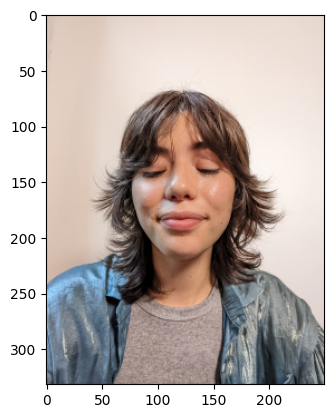

aqui crop FACE


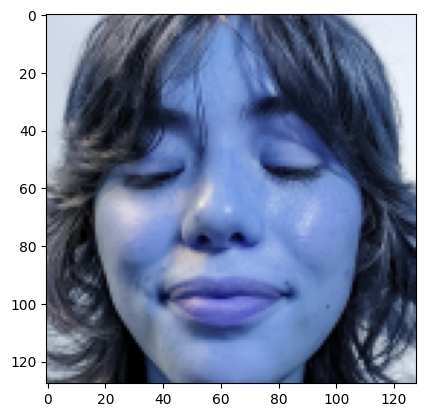

aqui crop FACE


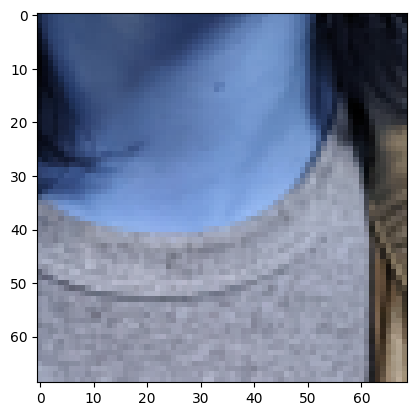

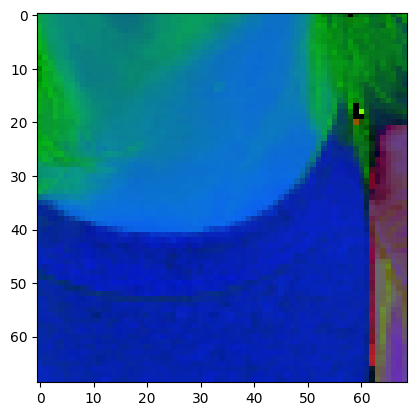

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'cluster_index': 0, 'color': [206.0305164319255, 148.86854460093986, 114.23474178403796], 'color_percentage': 0.1978683966635774}
Color Bar


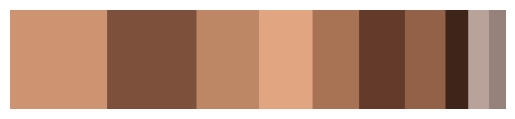

206.0305164319255
148.86854460093986
114.23474178403796
 2
 subject_1
 well_lit
1 151.42871416975004
2 141.13571226986025
3 139.70950102617155
4 113.70253209028574
5 75.30986431336535
6 78.80154595005347
7 113.91875072254003
8 154.64245625933842
9 193.8800947901969
10 216.82712674604392
list [151.42871416975004, 141.13571226986025, 139.70950102617155, 113.70253209028574, 75.30986431336535, 78.80154595005347, 113.91875072254003, 154.64245625933842, 193.8800947901969, 216.82712674604392]
minimo 75.30986431336535
5
151.42871416975004
/content/subject01/PXL_20220922_173952716.jpg


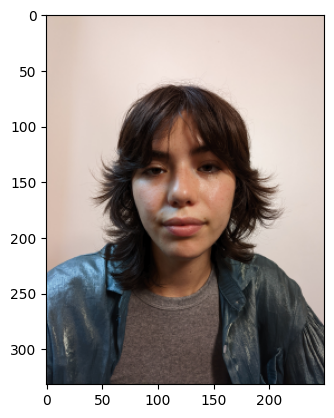

aqui crop FACE


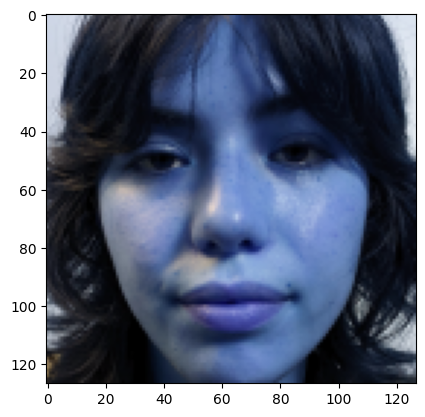

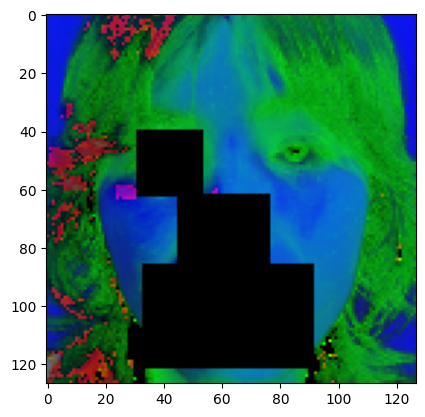

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'cluster_index': 6, 'color': [201.0559523809518, 142.36071428571512, 113.43333333333399], 'color_percentage': 0.16231379377055524}
Color Bar


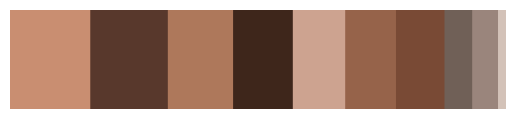

201.0559523809518
142.36071428571512
113.43333333333399
 2
 subject_1
 well_lit
1 156.91646116691243
2 146.47458604336703
3 144.76081117420503
4 117.99951402000241
5 77.22121639379797
6 70.85225791613199
7 105.77132600187578
8 146.79100651835347
9 186.24965215539228
10 209.2685266860212
list [156.91646116691243, 146.47458604336703, 144.76081117420503, 117.99951402000241, 77.22121639379797, 70.85225791613199, 105.77132600187578, 146.79100651835347, 186.24965215539228, 209.2685266860212]
minimo 70.85225791613199
6
156.91646116691243
/content/subject01/PXL_20220922_174009443.jpg


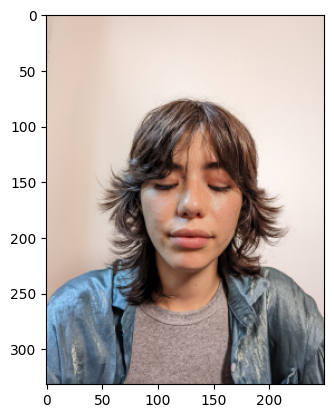

aqui crop FACE


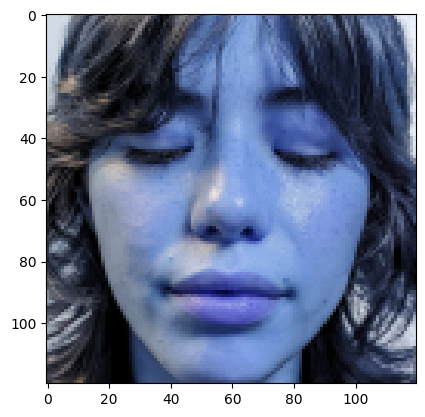

aqui crop FACE


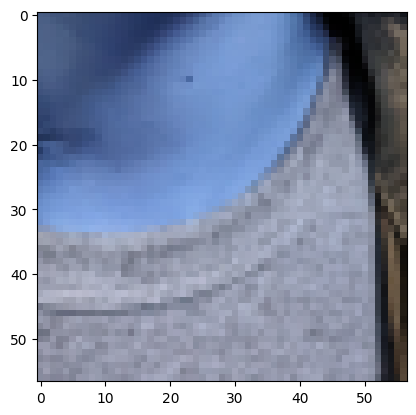

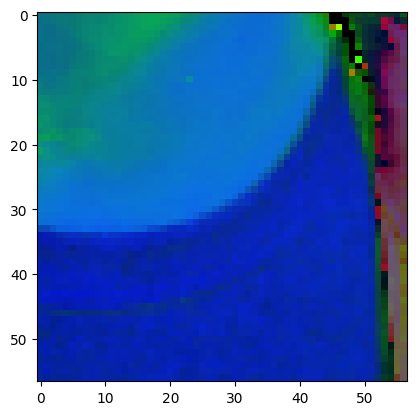

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'cluster_index': 7, 'color': [205.32020997375366, 147.15748031496014, 112.45144356955366], 'color_percentage': 0.24708171206225682}
Color Bar


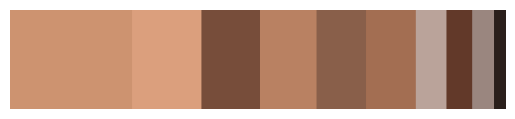

205.32020997375366
147.15748031496014
112.45144356955366
 2
 subject_1
 well_lit
1 153.95681607033066
2 143.64844044701658
3 142.17267201745153
4 116.06795189018976
5 77.2104898617881
6 77.31573068844946
7 111.87768868282987
8 152.5040781927885
9 191.80048389918716
10 214.72587152501575
list [153.95681607033066, 143.64844044701658, 142.17267201745153, 116.06795189018976, 77.2104898617881, 77.31573068844946, 111.87768868282987, 152.5040781927885, 191.80048389918716, 214.72587152501575]
minimo 77.2104898617881
5
153.95681607033066
/content/subject01/PXL_20220922_174011830.jpg


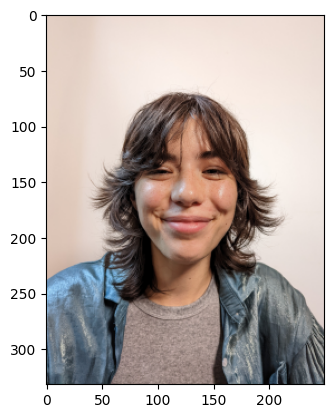

aqui crop FACE


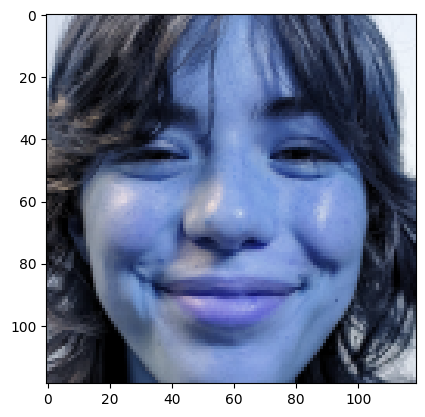

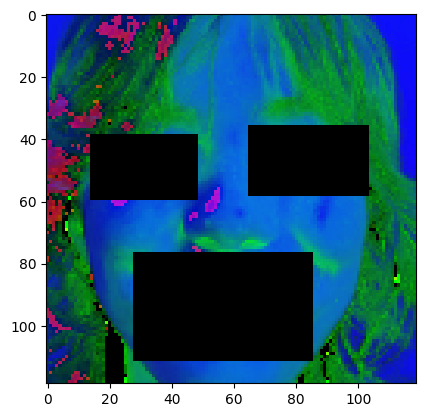

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'cluster_index': 3, 'color': [219.19387755101883, 161.33367346938684, 134.7030612244908], 'color_percentage': 0.14945859386914748}
Color Bar


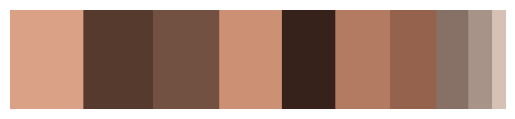

219.19387755101883
161.33367346938684
134.7030612244908
 2
 subject_1
 well_lit
1 125.0105234637324
2 114.7398670869256
3 113.18484230539339
4 88.12507552257748
5 55.62551863681828
6 96.20197904718201
7 136.66726448113917
8 178.8549701977304
9 218.10320145949237
10 241.2934963583541
list [125.0105234637324, 114.7398670869256, 113.18484230539339, 88.12507552257748, 55.62551863681828, 96.20197904718201, 136.66726448113917, 178.8549701977304, 218.10320145949237, 241.2934963583541]
minimo 55.62551863681828
5
125.0105234637324


In [27]:
from cv2 import imread
import dlib
from imutils import paths
import pandas as pd
import csv
import math

  # Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
  #
# input_image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/terry.jpg")
# # image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/jolie.jpg")
# input_image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/terry.jpg")
# input_image = imread("/content/PXL_20220922_174018423.jpg")
path = ("/content/subject01/")

imagePaths = list(paths.list_images(path))
for imagePath in imagePaths:
    input_image = cv2.imread(imagePath)
    print(imagePath)
    image = imutils.resize(input_image, width=250)

    #Show image
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.show()

    # Apply Skin Mask
    skin = extractSkin(image)

    # Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
    dominantColors = extractDominantColor(skin,hasThresholding=True)
    print(dominantColors[0])

    #Show in the dominant color information
    # print("Color Information")
    # prety_print_data(dominantColors)

    #Show in the dominant color as bar
    print("Color Bar")
    colour_bar = plotColorBar(dominantColors)
    plt.axis("off")
    plt.imshow(colour_bar)
    plt.show()

    #check CSV created
    dataset = pd.read_csv("/content/dataset_details.csv")
    #return values from csv
    image_name = imagePath.replace(path, '')

    color = dominantColors[0]

    df = pd.DataFrame.from_dict(color)
    r = df.loc[0, 'color']
    r = str(r)
    print(r)
    b = df.loc[1, 'color']
    b = str(b)
    print(b)
    g = df.loc[2, 'color']
    g = str(g)
    print(g)
    rgb =  r + ',' + g + ',' + b
    # print(rgb)
    img = dataset.loc[dataset['image_ID'] == image_name]
    mst = pd.DataFrame.from_dict(img.MST)
    mst = str(mst)
    mst = mst[15:17]
    print(mst)

    subject = pd.DataFrame.from_dict(img.subject_name)
    subject = str(subject)
    subject = subject[23:33]
    print(subject)

    r = float(r)
    g = float(g)
    b = float(b)

    light = pd.DataFrame.from_dict(img.lighting)
    light = str(light)
    light = light[18:30]
    print(light)
    list_distance = []
    # else : #(mst == 1)
    mst_rgb = "246, 237, 228"
    mst_r = 246
    mst_g = 237
    mst_b = 228
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("1", distancia)
    # elif (mst == 2):
    mst_rgb = "243, 231, 219"
    mst_r = 243
    mst_g = 231
    mst_b = 219
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("2", distancia)
    # elif (mst == 3):
    mst_rgb = "247, 234, 208"
    mst_r = 247
    mst_g = 234
    mst_b = 208
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("3",distancia)
    # elif (mst == 4):
    mst_rgb = "234, 218, 186"
    mst_r = 234
    mst_g = 218
    mst_b = 186
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("4",distancia)
    # elif (mst == 5):
    mst_rgb = "215, 189, 150"
    mst_r = 215
    mst_g = 189
    mst_b = 150
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("5",distancia)
    # elif (mst == 6):
    mst_rgb = "160, 126, 86"
    mst_r = 160
    mst_g = 126
    mst_b = 86
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("6",distancia)
    # elif (mst == 7):
    mst_rgb = "130, 92, 67"
    mst_r = 130
    mst_g = 92
    mst_b = 67
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("7",distancia)
    # elif (mst == 8):
    mst_rgb = "96, 65, 52"
    mst_r = 96
    mst_g = 65
    mst_b = 52
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("8",distancia)
    # elif (mst == 9):
    mst_rgb = "58, 49, 42"
    mst_r = 58
    mst_g = 49
    mst_b = 42
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("9",distancia)
    #  if(mst == 10):
    mst_rgb = "41, 36, 32"
    mst_r = 41
    mst_g = 36
    mst_b = 32
    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    list_distance.append(distancia)
    print("10", distancia)





    print("list", list_distance)
    minimo = min(list_distance)
    print("minimo",minimo)
    classificacao_indicada = list_distance.index(minimo)
    classificacao_indicada = classificacao_indicada + 1

    if (dataset.image_ID == image_name).any() == True:
    #Monk Palette colors in RGB
      if(mst == 10):
        mst_rgb = "41, 36, 32"
        mst_r = 41
        mst_g = 36
        mst_b = 32
      elif (mst == 9):
        mst_rgb = "58, 49, 42"
        mst_r = 58
        mst_g = 49
        mst_b = 42
      elif (mst == 8):
        mst_rgb = "96, 65, 52"
        mst_r = 96
        mst_g = 65
        mst_b = 52
      elif (mst == 7):
        mst_rgb = "130, 92, 67"
        mst_r = 130
        mst_g = 92
        mst_b = 67
      elif (mst == 6):
        mst_rgb = "160, 126, 86"
        mst_r = 160
        mst_g = 126
        mst_b = 86
      elif (mst == 5):
        mst_rgb = "215, 189, 150"
        mst_r = 215
        mst_g = 189
        mst_b = 150
      elif (mst == 4):
        mst_rgb = "234, 218, 186"
        mst_r = 234
        mst_g = 218
        mst_b = 186
      elif (mst == 3):
        mst_rgb = "247, 234, 208"
        mst_r = 247
        mst_g = 234
        mst_b = 208
      elif (mst == 2):
        mst_rgb = "243, 231, 219"
        mst_r = 243
        mst_g = 231
        mst_b = 219
      else : #(mst == 1)
        mst_rgb = "246, 237, 228"
        mst_r = 246
        mst_g = 237
        mst_b = 228

    distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
    print(distancia)

    with open('dataset_details_answer.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([image_name, subject, light, mst, mst_rgb, mst_r, mst_g, mst_b, rgb,  r, g, b, distancia, minimo, classificacao_indicada])


In [ ]:
from cv2 import imread
import dlib
from imutils import paths
import pandas as pd
import csv
import math

  # Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
  #
# input_image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/terry.jpg")
# # image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/jolie.jpg")
# input_image =  imutils.url_to_image("https://raw.githubusercontent.com/vittoria-thomasini/Extract_skintone_image/main/terry.jpg")
input_image = imread("/content/PXL_20220922_174011830.jpg")
# path = ("/content/subject01")

# imagePaths = list(paths.list_images(path))
# for imagePath in imagePaths:
#     input_image = cv2.imread(imagePath)
#     print(imagePath)
image = imutils.resize(input_image, width=250)

#Show image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()

# Apply Skin Mask
skin = extractSkin(image)

# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin,hasThresholding=True)
print(dominantColors[0])

#Show in the dominant color information
# print("Color Information")
# prety_print_data(dominantColors)

#Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.axis("off")
plt.imshow(colour_bar)
plt.show()



#check CSV created
dataset = pd.read_csv("/content/dataset_details.csv")
#return values from csv
image_name = 'PXL_20220922_174011830.jpg'

img = dataset.loc[dataset['image_ID'] == image_name]

color = dominantColors[0]
df = pd.DataFrame.from_dict(color)
r = df.loc[0, 'color']
r = str(r)
print(r)
b = df.loc[1, 'color']
b = str(b)
print(b)
g = df.loc[2, 'color']
g = str(g)
print(g)
rgb =  r + ',' + g + ',' + b
# print(rgb)
mst = pd.DataFrame.from_dict(img.MST)
mst = str(mst)
mst = mst[15:17]
print(mst)

subject = pd.DataFrame.from_dict(img.subject_name)
subject = str(subject)
subject = subject[23:33]
print(subject)
r = float(r)
g = float(g)
b = float(b)


#  if(mst == 10):
mst_rgb = "41, 36, 32"
mst_r = 41
mst_g = 36
mst_b = 32
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 9):
mst_rgb = "58, 49, 42"
mst_r = 58
mst_g = 49
mst_b = 42
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 8):
mst_rgb = "96, 65, 52"
mst_r = 96
mst_g = 65
mst_b = 52
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 7):
mst_rgb = "130, 92, 67"
mst_r = 130
mst_g = 92
mst_b = 67
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 6):
mst_rgb = "160, 126, 86"
mst_r = 160
mst_g = 126
mst_b = 86
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 5):
mst_rgb = "215, 189, 150"
mst_r = 215
mst_g = 189
mst_b = 150
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 4):
mst_rgb = "234, 218, 186"
mst_r = 234
mst_g = 218
mst_b = 186
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 3):
mst_rgb = "247, 234, 208"
mst_r = 247
mst_g = 234
mst_b = 208
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 2):
mst_rgb = "243, 231, 219"
mst_r = 243
mst_g = 231
mst_b = 219
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# else : #(mst == 1)
mst_rgb = "246, 237, 228"
mst_r = 246
mst_g = 237
mst_b = 228
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)

if (dataset.image_ID == image_name).any() == True:
#Monk Palette colors in RGB
  if(mst == 10):
    mst_rgb = "41, 36, 32"
    mst_r = 41
    mst_g = 36
    mst_b = 32
  elif (mst == 9):
    mst_rgb = "58, 49, 42"
    mst_r = 58
    mst_g = 49
    mst_b = 42
  elif (mst == 8):
    mst_rgb = "96, 65, 52"
    mst_r = 96
    mst_g = 65
    mst_b = 52
  elif (mst == 7):
    mst_rgb = "130, 92, 67"
    mst_r = 130
    mst_g = 92
    mst_b = 67
  elif (mst == 6):
    mst_rgb = "160, 126, 86"
    mst_r = 160
    mst_g = 126
    mst_b = 86
  elif (mst == 5):
    mst_rgb = "215, 189, 150"
    mst_r = 215
    mst_g = 189
    mst_b = 150
  elif (mst == 4):
    mst_rgb = "234, 218, 186"
    mst_r = 234
    mst_g = 218
    mst_b = 186
  elif (mst == 3):
    mst_rgb = "247, 234, 208"
    mst_r = 247
    mst_g = 234
    mst_b = 208
  elif (mst == 2):
    mst_rgb = "243, 231, 219"
    mst_r = 243
    mst_g = 231
    mst_b = 219
  else : #(mst == 1)
    mst_rgb = "246, 237, 228"
    mst_r = 246
    mst_g = 237
    mst_b = 228

distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print("distancia", distancia)

with open('dataset_details_answer.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([image_name, subject, mst, mst_rgb, mst_r, mst_g, mst_b, rgb,  r, g, b])


In [ ]:
import pandas as pd
import csv
import math

#check CSV created
dataset = pd.read_csv("/content/dataset_details.csv")
#return values from csv
image_name = imagePath.replace('/content/', '')
color = dominantColors[0]
df = pd.DataFrame.from_dict(color)
r = df.loc[0, 'color']
r = str(r)
print(r)
b = df.loc[1, 'color']
b = str(b)
print(b)
g = df.loc[2, 'color']
g = str(g)
print(g)
rgb =  r + ',' + g + ',' + b
print(rgb)

img = dataset.loc[dataset['image_ID'] == image_name]
mst = pd.DataFrame.from_dict(img.MST)
mst = str(mst)
# mst = mst[15:20]
print(mst)

subject = pd.DataFrame.from_dict(img.subject_name)
subject = str(subject)
# subject = subject[23:35]
print(subject)
r = float(r)
g = float(g)
b = float(b)

if (dataset.image_ID == image_name).any() == True:
    #Monk Palette colors in RGB
    if(mst == 10):
      mst_rgb = "41, 36, 32"
      mst_r = 41
      mst_g = 36
      mst_b = 32
    elif (mst == 9):
      mst_rgb = "58, 49, 42"
      mst_r = 58
      mst_g = 49
      mst_b = 42
    elif (mst == 8):
      mst_rgb = "96, 65, 52"
      mst_r = 96
      mst_g = 65
      mst_b = 52
    elif (mst == 7):
      mst_rgb = "130, 92, 67"
      mst_r = 130
      mst_g = 92
      mst_b = 67
    elif (mst == 6):
      mst_rgb = "160, 126, 86"
      mst_r = 160
      mst_g = 126
      mst_b = 86
    elif (mst == 5):
      mst_rgb = "215, 189, 150"
      mst_r = 215
      mst_g = 189
      mst_b = 150
    elif (mst == 4):
      mst_rgb = "234, 218, 186"
      mst_r = 234
      mst_g = 218
      mst_b = 186
    elif (mst == 3):
      mst_rgb = "247, 234, 208"
      mst_r = 247
      mst_g = 234
      mst_b = 208
    elif (mst == 2):
      mst_rgb = "243, 231, 219"
      mst_r = 243
      mst_g = 231
      mst_b = 219
    else : #(mst == 1)
      mst_rgb = "246, 237, 228"
      mst_r = 246
      mst_g = 237
      mst_b = 228


distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)

with open('dataset_details_answer.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([image_name, subject, mst, mst_rgb, mst_r, mst_g, mst_b, rgb,  r, g, b])


In [ ]:
# if(mst == 10):
mst_rgb = "41, 36, 32"
mst_r = 41
mst_g = 36
mst_b = 32
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 9):
mst_rgb = "58, 49, 42"
mst_r = 58
mst_g = 49
mst_b = 42
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 8):
mst_rgb = "96, 65, 52"
mst_r = 96
mst_g = 65
mst_b = 52
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 7):
mst_rgb = "130, 92, 67"
mst_r = 130
mst_g = 92
mst_b = 67
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 6):
mst_rgb = "160, 126, 86"
mst_r = 160
mst_g = 126
mst_b = 86
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 5):
mst_rgb = "215, 189, 150"
mst_r = 215
mst_g = 189
mst_b = 150
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 4):
mst_rgb = "234, 218, 186"
mst_r = 234
mst_g = 218
mst_b = 186
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 3):
mst_rgb = "247, 234, 208"
mst_r = 247
mst_g = 234
mst_b = 208
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# elif (mst == 2):
mst_rgb = "243, 231, 219"
mst_r = 243
mst_g = 231
mst_b = 219
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)
# else : #(mst == 1)
mst_rgb = "246, 237, 228"
mst_r = 246
mst_g = 237
mst_b = 228
distancia = math.sqrt(((mst_r - r)** 2) + ((mst_g - g)**2) + ((mst_b - b)**2))
print(distancia)